In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import pickle
from skimage.feature import hog
from scipy.ndimage.measurements import label

import glob
import os

from moviepy.editor import VideoFileClip
from collections import deque

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
with open('classifier_hist.p', 'rb') as _file:
    clf = pickle.load(_file)

In [5]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [6]:
image = cv2.imread('bbox-example-image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
test_images = glob.glob(os.path.join('../test_images', '*.jpg'))

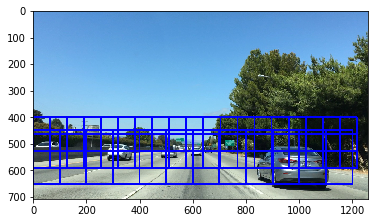

In [7]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[450, None], 
                    xy_window=(200, 200), xy_overlap=(0.5, 0.5))

windows = windows1 + windows2

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [8]:
def sliding_windows(img, ystart, ystop, scale, stride):
    orient = 9 
    pix_per_cell = 8 
    cell_per_block = 2
    
    # draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bboxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = stride  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            # subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            # spatial_features = bin_spatial(subimg, size=spatial_size)
            # hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
            bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))     
    return bboxes

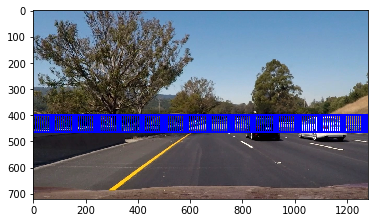

In [9]:
image = cv2.imread(test_images[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes1 = sliding_windows(image, ystart=400, ystop=470, scale=1.0, stride=1)
bboxes2 = sliding_windows(image, ystart=400, ystop=650, scale=1.5, stride=3)
bboxes3 = sliding_windows(image, ystart=400, ystop=650, scale=2.0, stride=3)

window_img = draw_boxes(image, bboxes1, color=(0, 0, 255), thick=3)
# window_img = draw_boxes(window_img, bboxes2, color=(0, 255, 0), thick=3)  
# window_img = draw_boxes(window_img, bboxes3, color=(255, 0, 0), thick=3)  
plt.imshow(window_img)

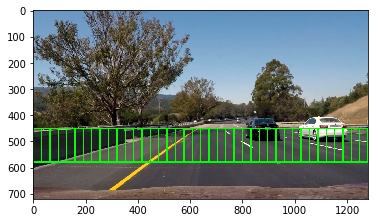

In [10]:
bboxes2 = sliding_windows(image, ystart=450, ystop=600, scale=2.0, stride=2)
window_img = draw_boxes(image, bboxes2, color=(0, 255, 0), thick=3)  
plt.imshow(window_img)

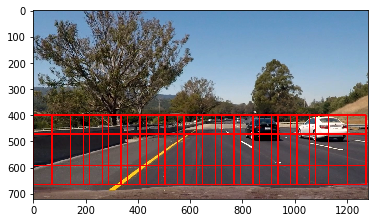

In [11]:
bboxes3 = sliding_windows(image, ystart=400, ystop=670, scale=3.0, stride=3)
window_img = draw_boxes(image, bboxes3, color=(255, 0, 0), thick=3)  
plt.imshow(window_img)

In [12]:
def hog_feature(image):
    return hog(image, orientations=13, 
               pixels_per_cell=(8, 8), 
               cells_per_block=(2, 2), 
               feature_vector=False)
    
def feature_extractor(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb).astype(np.float32)/255
    # HOG Features
    rhf = hog_feature(img[:, :, 0])
    ghf = hog_feature(img[:, :, 1])
    bhf = hog_feature(img[:, :, 2])
    return np.hstack((rhf, ghf, bhf))

def feature_extractor_w_hist(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb).astype(np.float32)/255
    # HOG Features
    rhf = hog_feature(img[:, :, 0])
    ghf = hog_feature(img[:, :, 1])
    bhf = hog_feature(img[:, :, 2])
    # Histogram Features
    channel1_hist = np.histogram(img[:,:,0], bins=32)
    channel2_hist = np.histogram(img[:,:,1], bins=32)
    channel3_hist = np.histogram(img[:,:,2], bins=32)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return np.hstack((rhf, ghf, bhf, hist_features))

In [13]:
def find_cars(img, ystart, ystop, scale, clf, stride):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    # draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bboxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = stride  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = hog(ch1, orientations=orient, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    hog2 = hog(ch2, orientations=orient, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    hog3 = hog(ch3, orientations=orient, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            # spatial_features = bin_spatial(subimg, size=spatial_size)
            # hist_features = color_hist(subimg, nbins=hist_bins)
            channel1_hist = np.histogram(subimg[:,:,0], bins=32)
            channel2_hist = np.histogram(subimg[:,:,1], bins=32)
            channel3_hist = np.histogram(subimg[:,:,2], bins=32)
            # Concatenate the histograms into a single feature vector
            hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

            # Scale features and make a prediction
            # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_features = np.hstack((hog_features, hist_features)).reshape(1, -1)
            # test_features = hog_features.reshape(1, -1)
            # print(hog_features.shape, hist_features.shape, test_features.shape)
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bboxes

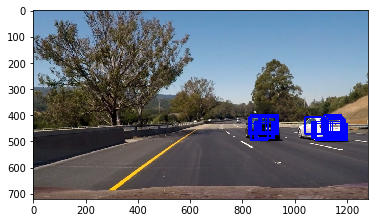

In [14]:
bboxes = find_cars(image, ystart=400, ystop=500, 
                     scale=1., clf=clf, stride=1)
draw_img = draw_boxes(image, bboxes)
plt.imshow(draw_img)

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [16]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [17]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        area = (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1])
        if area > 2000:
            # Draw the box on the image
            # print(area)
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

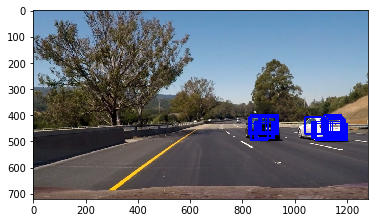

In [18]:
bboxes1 = find_cars(image, ystart=400, ystop=500, 
                     scale=1., clf=clf, stride=1)
bboxes2 = find_cars(image, ystart=450, ystop=600, 
                     scale=2.0, clf=clf, stride=2)
bboxes3 = find_cars(image, ystart=400, ystop=670, 
                     scale=3.0, clf=clf, stride=3)

bboxes = bboxes1 + bboxes2 + bboxes3
draw_img = draw_boxes(image, bboxes)
plt.imshow(draw_img)

In [19]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

labels = label(heatmap)

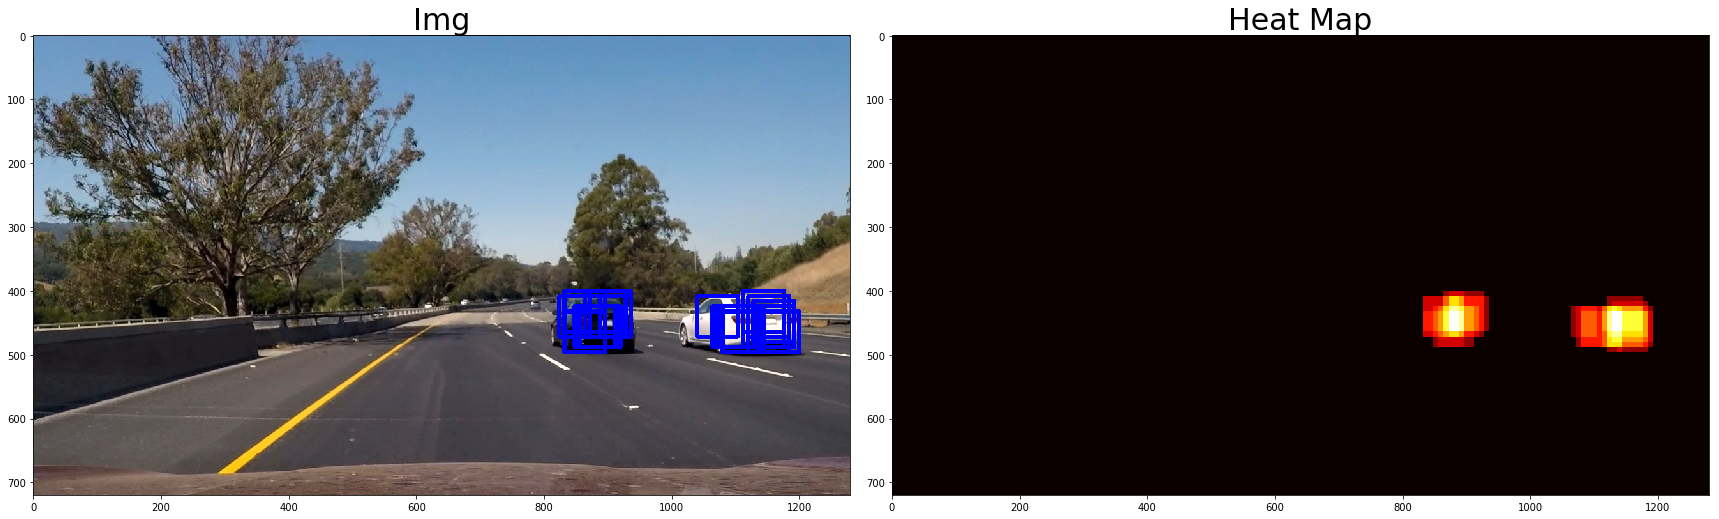

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Img', fontsize=30)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=30)

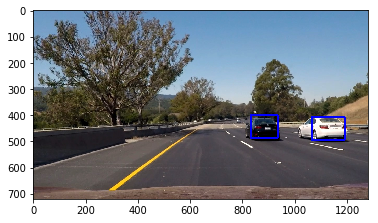

In [21]:
box_img = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(box_img)

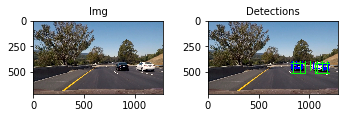

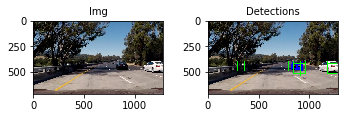

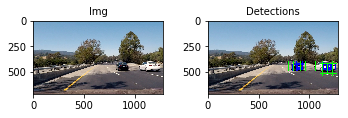

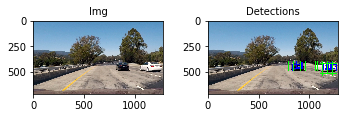

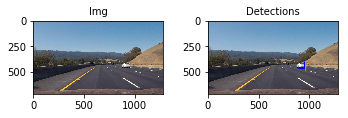

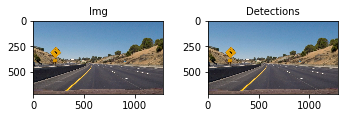

In [22]:
def pipeline_test(image):
    bboxes1 = find_cars(image, ystart=400, ystop=500, 
                     scale=1., clf=clf, stride=1)
    bboxes2 = find_cars(image, ystart=400, ystop=600, 
                         scale=1.5, clf=clf, stride=2)
    bboxes3 = find_cars(image, ystart=400, ystop=670, 
                         scale=3.0, clf=clf, stride=3)
    bboxes = bboxes2 + bboxes1 + bboxes3
    
    window_img = draw_boxes(image, bboxes1, color=(0, 0, 255), thick=3)
    window_img = draw_boxes(window_img, bboxes2, color=(0, 255, 0), thick=3)  
    window_img = draw_boxes(window_img, bboxes3, color=(255, 0, 0), thick=3)  
    return window_img

for test_image in test_images:
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    box_img = pipeline_test(image)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Img', fontsize=10)
    ax2.imshow(box_img, cmap='hot')
    ax2.set_title('Detections', fontsize=10)

In [23]:
def detect(image):
    bboxes1 = find_cars(image, ystart=400, ystop=500, 
                     scale=1., clf=clf, stride=1)
    bboxes2 = find_cars(image, ystart=400, ystop=600, 
                         scale=1.5, clf=clf, stride=2)
    bboxes3 = find_cars(image, ystart=400, ystop=670, 
                         scale=3.0, clf=clf, stride=3)
    bboxes = bboxes2 + bboxes1 + bboxes3
    # draw_img = draw_boxes(image, bboxes)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # labels = label(heatmap)
    # box_img = draw_labeled_bboxes(np.copy(image), labels)
    return heatmap

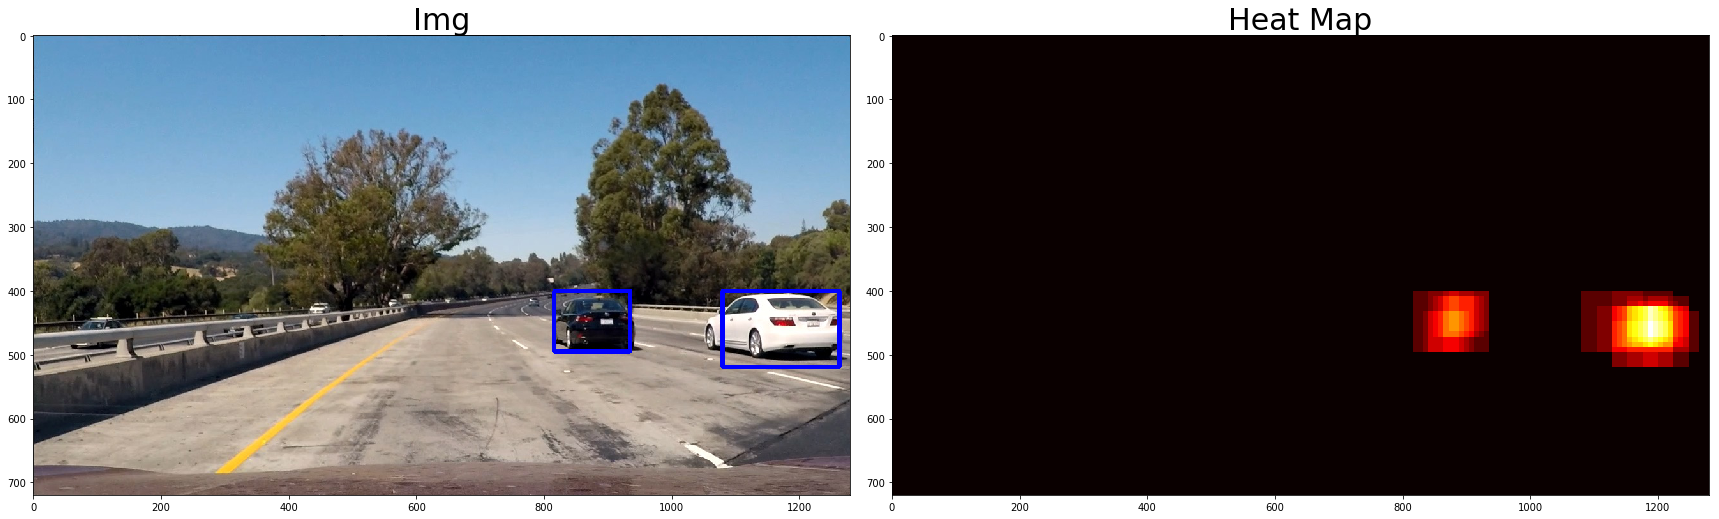

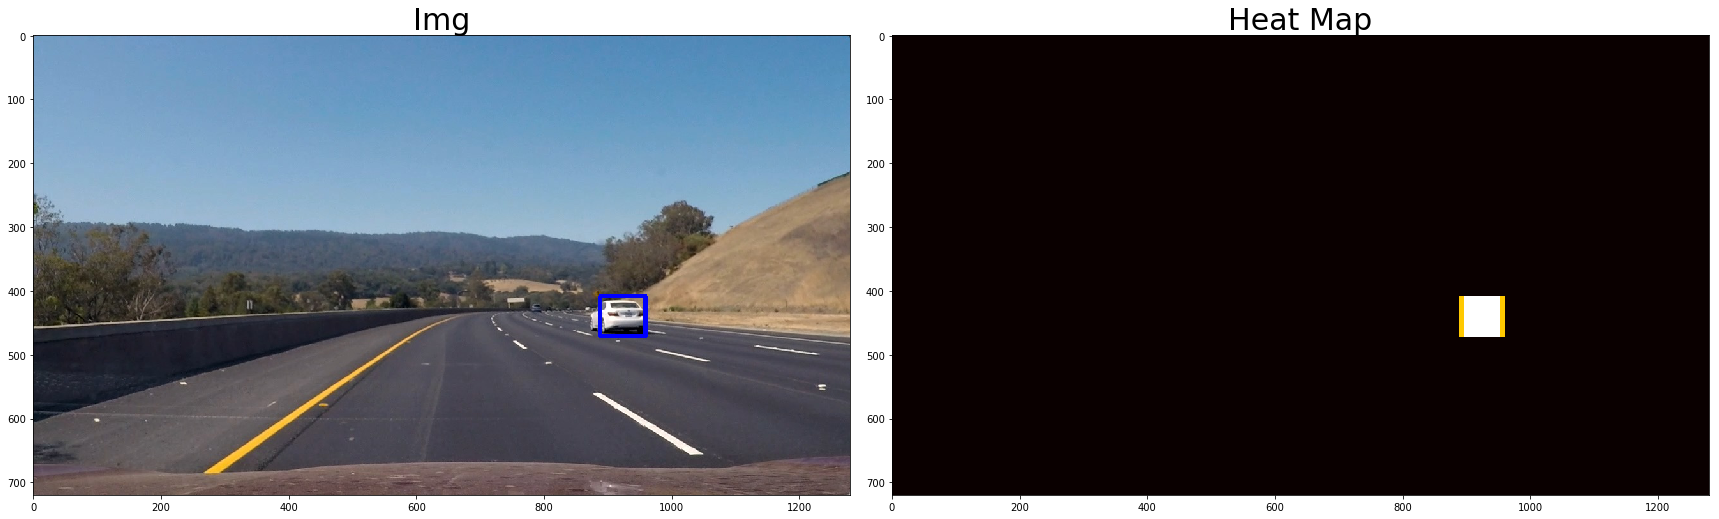

In [24]:
for test_image in test_images:
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    heatmap = detect(image)
    labels = label(heatmap)
    # print(labels)
    box_img = draw_labeled_bboxes(np.copy(image), labels)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(box_img)
    ax1.set_title('Img', fontsize=30)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)

In [31]:
queue = deque(maxlen=6)
def detect_vehicles(test_image):
    heatmap = detect(test_image)
    curr_labels = label(heatmap)
    queue.append(heatmap)
    avg_heatmap = heatmap
    if curr_labels[1]:
        if len(queue) > 1:
            avg_heatmap = sum(list(queue))
    else:
        if len(queue) > 1:
            avg_heatmap = queue[-1] + queue[-2]
    avg_heatmap = apply_threshold(avg_heatmap, 1)
    labels = label(avg_heatmap)
    # print(labels)
    result = draw_labeled_bboxes(np.copy(test_image), labels)
    # queue.append(avg_heatmap)
    return result

In [26]:
output = os.path.join("../", "test_video_hist.mp4")
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(os.path.join("../", "test_video.mp4"))
lane = clip1.fl_image(detect_vehicles) #NOTE: this function expects color images!!
%time lane.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../test_video_hist.mp4
[MoviePy] Writing video ../test_video_hist.mp4


 97%|█████████▋| 38/39 [00:51<00:01,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_video_hist.mp4 

CPU times: user 47.2 s, sys: 1.44 s, total: 48.6 s
Wall time: 52.8 s


In [27]:
queue = deque(maxlen=6)

In [32]:
output = os.path.join("../", "project_video_hist.mp4")
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(os.path.join("../", "project_video.mp4"))
lane = clip1.fl_image(detect_vehicles) #NOTE: this function expects color images!!
%time lane.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../project_video_hist.mp4
[MoviePy] Writing video ../project_video_hist.mp4


100%|█████████▉| 1260/1261 [24:34<00:01,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_hist.mp4 

CPU times: user 23min 6s, sys: 43.4 s, total: 23min 50s
Wall time: 24min 36s
